In [39]:
import os, sys
import iris
import iris.plot as iplt
import matplotlib.pyplot as plt

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)
import general_io as gio
import convenient_universal as uconv

In [40]:
% matplotlib inline

## Read data

In [58]:
def get_data(model, experiment, mip, inferred=False):
    """Get the data files"""

    if inferred:
        insert = '-inferred-'
    else:
        insert = '-'
        
    
    ohc_globe_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/%s/ohc/latest/dedrifted/ohc-globe-sum_Oyr_%s_%s_%s_all.nc' %(model, experiment, mip, model, experiment, mip)
    hfds_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/%s/hfds/latest/hfds%ssum-hemispheric-metrics_Oyr_%s_%s_%s_all.nc' %(model, experiment, mip, insert, model, experiment, mip)
    
    print(ohc_globe_file)
    print(hfds_file)
    
    ohc_globe_cube = iris.load_cube(ohc_globe_file, 'ocean heat content globe sum')
    hfds_globe_cube_W = iris.load_cube(hfds_file, 'Downward Heat Flux at Sea Water Surface globe sum')
    
    return ohc_globe_cube, hfds_globe_cube_W

In [56]:
def convert_to_joules(cube):
    """Convert units to Joules"""

    assert 'W' in str(cube.units)
    assert 'days' in str(cube.coord('time').units)
    
    time_span_days = cube.coord('time').bounds[:, 1] - cube.coord('time').bounds[:, 0]
    time_span_seconds = time_span_days * 60 * 60 * 24
    
    cube.data = cube.data * uconv.broadcast_array(time_span_seconds, 0, cube.shape)
    cube.units = str(cube.units).replace('W', 'J')
    
    return cube

In [59]:
ohc_globe_cube, hfds_globe_cube_W = get_data('CanESM2', 'historical', 'r1i1p1', inferred=True)

/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/historical/yr/ocean/r1i1p1/ohc/latest/dedrifted/ohc-globe-sum_Oyr_CanESM2_historical_r1i1p1_all.nc
/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/historical/yr/ocean/r1i1p1/hfds/latest/hfds-inferred-sum-hemispheric-metrics_Oyr_CanESM2_historical_r1i1p1_all.nc


In [60]:
hfds_globe_cube_J = convert_to_joules(hfds_globe_cube_W)

## Change in OHC

In [28]:
start_time_constraint = gio.get_time_constraint(['1861-01-01', '1880-12-31'])
end_time_constraint = gio.get_time_constraint(['1986-01-01', '2005-12-31'])

In [29]:
start_ohc = ohc_globe_cube.extract(start_time_constraint)

In [30]:
start_ohc

<iris 'Cube' of ocean heat content globe sum / (J) (time: 20)>

In [32]:
end_ohc = ohc_globe_cube.extract(end_time_constraint)

In [33]:
end_ohc

<iris 'Cube' of ocean heat content globe sum / (J) (time: 20)>

In [35]:
ohc_change = end_ohc.data.mean() - start_ohc.data.mean()
print(ohc_change)

2.03924261912e+23


## Heat added

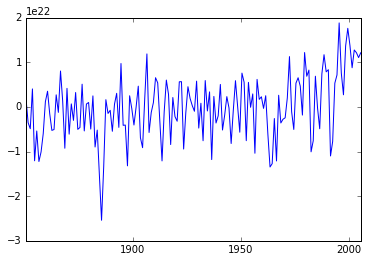

In [43]:
iplt.plot(hfds_globe_cube_J)
plt.show()

In [37]:
hfds_globe_cube_J_anomaly = hfds_globe_cube_J.data - hfds_globe_cube_J.data[0:20].mean()

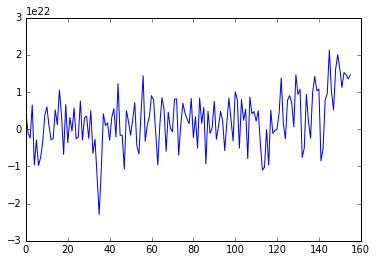

In [44]:
plt.plot(hfds_globe_cube_J_anomaly)
plt.show()

In [51]:
hfds_globe_cube_J_anomaly.sum()

3.6214573211086181e+23